# Mapping

This is adapted from the given intro_coppelia file from near the beginning of Lehigh University's Mobile Robotics course.

Also adapted from Dr. David Saldana's code here:
https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/coppelia/Camera.ipynb

In [1]:
# Import the python library that connects to CoppeliaSim, the file is sim.py.
try:
    import sim
except:
    print('--------------------------------------------------------------')
    print('"sim.py" could not be imported. This means very probably that')
    print('either "sim.py" or the remoteApi library could not be found.')
    print('Make sure both are in the same folder as this file,')
    print('or appropriately adjust the file "sim.py"')
    print('--------------------------------------------------------------')
    print('')

import time
import numpy as np
import cv2

%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Check if python is connecting to Coppelia

In [2]:
print('Program started')
sim.simxFinish(-1)  # just in case, close all opened connections
clientID = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim

if clientID != -1:
    print('Connected to remote API server')

    # Now try to retrieve data in a blocking fashion (i.e. a service call):
    res, objs = sim.simxGetObjects(clientID, sim.sim_handle_all, sim.simx_opmode_blocking)

    # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive. You can guarantee this with (for example):
    sim.simxGetPingTime(clientID)

    # Now close the connection to CoppeliaSim:
    sim.simxFinish(clientID)
else:
    print('Failed connecting to remote API server')
print('Program ended')

Program started
Connected to remote API server
Program ended


# Object oriented programming

In [3]:
class robot():
    
    def __init__(self, motor_names, frame_name=None):        
        self.client_id = self.open_connection()
        self.motors = self._get_handlers(motor_names) 
        
        # Robot frame
        self.frame = self._get_handler(frame_name)
            
        
    def open_connection(self):
        sim.simxFinish(-1)  # just in case, close all opened connections
        self.client_id = sim.simxStart('127.0.0.1', 19999, True, True, 5000, 5)  # Connect to CoppeliaSim 
        
        if clientID != -1:
            print('Robot connected')
        else:
            print('Connection failed')
        return clientID
        
    def close_connection(self):    
        sim.simxGetPingTime(self.client_id)  # Before closing the connection to CoppeliaSim, make sure that the last command sent out had time to arrive.
        sim.simxFinish(self.client_id)  # Now close the connection to CoppeliaSim:
        print('Connection closed')
    
    def isConnected(self):
        c,result = sim.simxGetPingTime(self.client_id)
        # Return true if the robot is connected
        return result > 0         
        
    def _get_handler(self, name):
        err_code, handler = sim.simxGetObjectHandle(self.client_id, name, sim.simx_opmode_blocking)
        return handler
    
    def _get_handlers(self, names):
        handlers = []
        for name in names:
            handler = self._get_handler(name)
            handlers.append(handler)
        
        return handlers

    def send_motor_velocities(self, vels):
        for motor, vel in zip(self.motors, vels):
            err_code = sim.simxSetJointTargetVelocity(self.client_id, 
                                                      motor, vel, sim.simx_opmode_streaming)      
            
    def set_position(self, position, relative_object):
        relative_handle = self._get_handler(relative_object)
        sim.simxSetObjectPosition(clientID, self.frame, relative_handle, position, sim.simx_opmode_oneshot)
    
    def get_position(self, relative_object=-1):
        if relative_object != -1:
            relative_object = self.get_handler(relative_object)
        res, position = sim.simxGetObjectPosition(self.client_id, self.frame, relative_object, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_position(self, object_name):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, -1, sim.simx_opmode_blocking)
        return array(position)
    
    def get_object_relative_position(self, object_name):
        err_code, object_h = sim.simxGetObjectHandle(self.client_id, object_name, sim.simx_opmode_blocking)
        res, position = sim.simxGetObjectPosition(self.client_id, object_h, self.frame, sim.simx_opmode_blocking)
        return array(position)

# Get Images

We take one image per second for 100 seconds, also storing the orientations

In [4]:
def get_images(r, count):
    res, sensor = sim.simxGetObjectHandle(clientID, 'Vision_sensor', sim.simx_opmode_oneshot_wait)
    err, resolution, image = sim.simxGetVisionSensorImage(clientID, sensor, 1, sim.simx_opmode_streaming)
    
    images = []
    orientations = []
    
    i = 0
    #Loop until image get is successful, then reshape the image from a vector,
    #then append to list
    while(i < count):
        err, resolution, image = sim.simxGetVisionSensorImage(clientID, sensor, 1, sim.simx_opmode_buffer)
        if err == sim.simx_return_ok:
            image = np.asarray(image, dtype=np.uint8)
            image.resize([resolution[1],resolution[0]])
            #flip image right-side-up and fix colors
            image = image[::-1,:]
            #print(image.shape)
            images.append(image)
            err, direction = sim.simxGetObjectOrientation(clientID,r.frame, -1,  sim.simx_opmode_blocking)
            print(direction)
            orientations.append(direction)
            
            i+=1
            
        elif err == sim.simx_return_novalue_flag:
            print("ERROR")
        
        time.sleep(1)
    
    return images, orientations

motor_names = []
r = robot(motor_names, 'Pioneer_p3dx')  # Create an instance of our robot
#Get 100 images, one per second
images, orientations = get_images(r, 180)
    
#cv2.imshow("image", images[0])
#cv2.waitKey(0)
#cv2.destroyAllWindows()

r.close_connection()

Robot connected
ERROR
[0.0010217252420261502, -0.001804811879992485, 0.5783894062042236]
[0.0011669349623844028, -0.0026334866415709257, 0.4642017185688019]
[0.0011434888001531363, -0.0035536910872906446, 0.3471939265727997]
[0.0008095792145468295, -0.0037942836061120033, 0.24180544912815094]
[0.00034975571907125413, -0.0035707310307770967, 0.13401596248149872]
[-5.478563980432227e-05, -0.0028733599465340376, 0.025352898985147476]
[-0.00029155673109926283, -0.0022481316700577736, -0.0791684165596962]
[-0.00047615254879929125, -0.0016253035282716155, -0.17772622406482697]
[-0.0006019957945682108, -0.0016863722121343017, -0.2907082736492157]
[-0.0009977611480280757, -0.002110011177137494, -0.40508323907852173]
[-0.001639326335862279, -0.002672826638445258, -0.5231791734695435]
[-0.0022489260882139206, -0.0029506629798561335, -0.6326003670692444]
[-0.002686462365090847, -0.0028072309214621782, -0.7470877766609192]
[-0.0026769815012812614, -0.002227137330919504, -0.8604485988616943]
[-0.00

[0.0009347696322947741, -0.0029805649537593126, 0.3158721923828125]
[0.0007306731422431767, -0.003648602869361639, 0.2044370174407959]
[0.0003247874556109309, -0.0038655567914247513, 0.09287185966968536]
[-0.00010037258471129462, -0.003583576064556837, -0.013707195408642292]
[-0.00033683967194519937, -0.0030807333532720804, -0.09670675545930862]
[-0.00048397656064480543, -0.002576282015070319, -0.16980692744255066]
[-0.0005987404147163033, -0.001963846618309617, -0.278753399848938]
[-0.0007345084450207651, -0.001684249029494822, -0.38972964882850647]
[-0.0011232872493565083, -0.0019423591438680887, -0.5034849047660828]
[-0.0017804966773837805, -0.00241375551559031, -0.6186960935592651]
[-0.002531986450776458, -0.0026974985376000404, -0.7342250347137451]
[-0.003158212173730135, -0.0026366717647761106, -0.854411780834198]
[-0.00281310873106122, -0.0018054493702948093, -0.9749261140823364]
[-0.0027834661304950714, -0.0013176662614569068, -1.0957860946655273]
[-0.002109118737280369, -0.000

### Get circles in each image

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

        [ 128.5       ,  116.5       ,   21.5058136 ]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

        [ 229.5       ,  110.5       ,   25.7390728 ]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  5

        [   4.5       ,  110.5       ,   30.20761108]]], dtype=float32), array([[[ 150.5       ,  114.5       ,   28.15137482]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 22

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

        [  36.5       ,  105.5       ,   45.63441467]]], dtype=float32), array([[[ 200.5      ,  110.5      ,   21.5058136]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5

        [  36.5       ,  105.5       ,   45.63441467]]], dtype=float32), array([[[ 200.5      ,  110.5      ,   21.5058136]]], dtype=float32), array([[[ 170.5       ,  113.5       ,   24.13503647]]], dtype=float32), array([[[ 152.5       ,  116.5       ,   22.63845825]]], dtype=float32), array([[[ 126.5       ,  114.5       ,   23.11925507]]], dtype=float32), array([[[ 102.5       ,  113.5       ,   22.32711411]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

        [ 243.5       ,  112.5       ,   39.5284729 ]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  5

        [ 185.5       ,  114.5       ,   20.50609589]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

        [ 164.5       ,  128.5       ,   54.13409042]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

        [  20.5       ,  108.5       ,   29.09467125]]], dtype=float32), array([[[ 168.5       ,  114.5       ,   27.50454521]]], dtype=float32), array([[[ 141.5       ,  115.5       ,   28.15137482]]], dtype=float32)]
[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=floa

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

[array([[[  94.5       ,  112.5       ,   21.78302002],
        [ 254.5       ,   91.5       ,   47.10095215]]], dtype=float32), array([[[  65.5       ,  116.5       ,   25.50489998],
        [ 235.5       ,   99.5       ,   60.6671257 ]]], dtype=float32), array([[[ 204.5       ,  100.5       ,   57.8662262 ],
        [  34.5       ,  116.5       ,   25.62225533]]], dtype=float32), array([[[ 180.5       ,  105.5       ,   55.9866066 ],
        [  14.5       ,  113.5       ,   25.62225533]]], dtype=float32), array([[[ 145.5       ,   96.5       ,   41.71929932]]], dtype=float32), array([[[ 133.5       ,  105.5       ,   47.67074585]]], dtype=float32), array([[[ 102.5       ,  105.5       ,   51.90856934],
        [ 242.5       ,  103.5       ,   41.81506729]]], dtype=float32), array([[[  80.5       ,  104.5       ,   54.79507446],
        [ 222.5       ,  112.5       ,   28.39894295]]], dtype=float32), array([[[  51.5       ,  103.5       ,   58.33094788],
        [ 195.5       ,  109.5

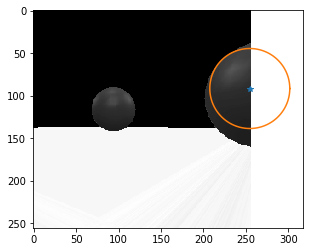

In [5]:
#Convert all images to grayscale and get circles
circles = []
for image in images:
    #image = cv2.cvtColor(image, cv2.COLOR_2GRAY)
    image = cv2.medianBlur(image,5)
    circles.append(cv2.HoughCircles(image, cv2.HOUGH_GRADIENT, 1, image.shape[0] / 8, param1=30,param2=15,minRadius=10,maxRadius=0))
    print(circles)
#get center and radius of each circle
centers = []
radii = []
    
for circleSet in circles:
    #preset biggest circle to first radius in circleSet
    biggestCenter = (circleSet[0][0][0], circleSet[0][0][1])
    biggestRadius = circleSet[0][0][2]
    for circle in circleSet[0, :]:
        center = (circle[0], circle[1])  # In pixels
        radius = circle[2]  # In pixels
        if radius > biggestRadius:
            biggestCenter = center
            biggestRadius = radius
    
    centers.append(biggestCenter)
    radii.append(biggestRadius)

imshow(images[0], cmap='gray')
# plot circle
s = linspace(0,2*pi,100)
cx = cos(s)*radii[0] + centers[0][0]
cy = sin(s)*radii[0] + centers[0][1]
# Plot center
plot(centers[0][0], centers[0][1], '*')

plot(cx,cy)
    
#cv2.imshow("image", images[0])
#cv2.waitKey(0)
#cv2.destroyAllWindows()

### Get Relative Coordinates of Spheres

In [6]:
relObstacles = []
i = 0

u0, v0 = 132, 132
fov = 60  # degrees

npx = 264 # number of pixels in x-axis

while i < len(centers):
    # Pixels per meters (radius in pixels / radius in  meters)
    k = radii[i] / (1.5 / 2)  

    # maximum value in the x-axis (in meters)
    xmax = npx / (2.* k)

    # Distance to the center of the sphere (z-axis coordinate)
    zc = xmax / tan(pi/6)

    # Location of the sphere in the x-axis coordinate
    xc = (centers[i][0] - u0) / k
    
    #append as tuple to relObstacles
    relObstacles.append((xc, zc))
    
    i+=1
    

### Construct Grid Representation of Env

This section taken directly from Dr. David Saldana's code here: https://github.com/dsaldana/CSE360-MobileRobotics/blob/master/coppelia/Camera.ipynb

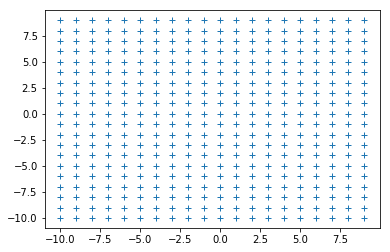

In [7]:
# Tha map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 20/n
grid_x, grid_y = np.mgrid[-10:10:cell_w,-10:10:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

plot(grid_x, grid_y, '+')

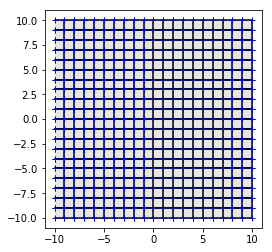

In [8]:
# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

### Convert From Camera Frame Coords to World Frame Coords

In [9]:
obstacleCoords = []
i = 0
while i < len(relObstacles):
    rotMatrix = np.array([[cos(orientations[i][2]), -1*sin(orientations[i][2])],
                 [sin(orientations[i][2]), cos(orientations[i][2])]])
    
    obstacle = np.array([relObstacles[i][0], relObstacles[i][1]]).T
    calc = np.matmul(rotMatrix,obstacle)
    print(calc)
    obstacleCoords.append(calc)
    
    i+=1

[-0.35687591  4.11473228]
[-0.12130751  3.10021358]
[-0.12468398  3.10618333]
[-0.10258677  3.12922367]
[-0.30866253  4.10573375]
[-0.06759354  3.59647075]
[-0.16364598  3.3267285 ]
[-0.14055123  3.2046789 ]
[-0.14901645  3.11298813]
[-0.05527372  3.37545159]
[ 3.05237383  5.05927292]
[ 2.94795404  4.97978979]
[ 2.89521142  4.80546552]
[ 3.2166027   5.39594518]
[ 2.64337203  4.25669117]
[ 7.5038763   1.99363445]
[ 7.43753948  1.92080276]
[ 9.18493269  2.3859189 ]
[ 7.3916467   1.84230856]
[ 7.49478419  1.84752504]
[ 3.27384737 -2.12604347]
[ 5.56981822 -3.45419499]
[ 3.18414117 -2.17127453]
[ 3.46391563 -2.39121678]
[ 4.31651971 -2.75344017]
[ 2.97575647 -2.07487258]
[ 3.17282093 -2.11516454]
[ 3.46231291 -2.3061005 ]
[ 3.3624581 -2.2304246]
[ 11.08040579 -12.36510645]
[ 11.3244704  -12.86536515]
[ 4.1037583  -4.31895813]
[-0.7496164  -4.86744214]
[-1.10078942 -6.53445459]
[-0.89599199 -6.42634968]
[-1.00590239 -6.34121995]
[-0.79081189 -5.49844623]
[-0.94687617 -5.69555454]
[-0.905909

### Calculate!

In [10]:
l0 = (0.3/(1-0.3))  # Initial belief
gmap = l0 * ones(n*n) # Initial belief

# For each cell, check if the circle is in it.
count = 0
while count < len(obstacleCoords):
    for i in range(n*n):
        x, y = grid_x[i], grid_y[i]
        #TODO Run this for each sphere (center and radius)
        # Corners of the cell
        X, Y = points_cell(x, y, cell_w)
        # check based on the ecuclidean distance
        dist = sqrt((obstacleCoords[count][1] - X)**2 + (obstacleCoords[count][0] - Y)**2)

        # Check if At least one of the borders is within the sphere
        if((dist < radii[count]/k).any()):
            print(dist)
            po = 0.8  # P(mi/zt) probability of having an obstacle 
            li = log(po / (1-po)) + gmap[i] - l0
            gmap[i] = li  # P(mi/zt) 
            print(li)
        """
        NOTE: Unknown why this isn't working. My thought process was that simply making sure
            it was within pi/6 radians of the orientation would work, but it produces very strange results that
            don't make a lot of sense to me. Leaving it uncommented, on the other hand, produces a "proper" set.
        else: 
            po = 0.05  # P(mi/zt) probability of having an obstacle given a non-detected obstacle

            # Cells within the fov. Check if the four points are withing the FOV
            thetas = np.arctan2(Y,X) -pi/2
            if np.logical_and(orientations[count][2]-pi/6 <thetas, thetas < orientations[count][2] + pi/6).all():
                li = log(po / (1-po)) + gmap[i] - l0
                gmap[i] = li

            pass"""
        
    count+=1

# gmap

[ 2.67804955  1.98556915  1.28694858  2.21036224]
1.38629436112
[ 2.21036224  1.28694858  1.17046507  2.14463355]
1.38629436112
[ 2.14463355  1.17046507  1.75605817  2.51260918]
1.38629436112
[ 2.51260918  1.75605817  2.60720005  3.16653702]
1.38629436112
[ 2.86857683  2.64561306  1.64712485  1.98556915]
1.38629436112
[ 1.98556915  1.64712485  0.65327796  1.28694858]
1.38629436112
[ 1.28694858  0.65327796  0.37486519  1.17046507]
1.38629436112
[ 1.17046507  0.37486519  1.36171794  1.75605817]
1.38629436112
[ 1.75605817  1.36171794  2.35966683  2.60720005]
1.38629436112
[ 2.64561306  2.78743679  1.86642859  1.64712485]
1.38629436112
[ 1.64712485  1.86642859  1.09421548  0.65327796]
1.38629436112
[ 0.65327796  1.09421548  0.95449429  0.37486519]
1.38629436112
[ 0.37486519  0.95449429  1.6201269   1.36171794]
1.38629436112
[ 1.36171794  1.6201269   2.51765029  2.35966683]
1.38629436112
[ 2.78743679  3.24658887  2.50081809  1.86642859]
1.38629436112
[ 1.86642859  2.50081809  1.99194452  1.

[ 2.38832349  3.08401485  2.57804862  1.68501518]
6.17490902386
[ 1.68501518  2.57804862  2.40447952  1.40515595]
6.17490902386
[ 1.40515595  2.40447952  2.62996365  1.76342006]
6.17490902386
[ 1.76342006  2.62996365  3.1704725   2.49896726]
6.17490902386
[ 2.96409541  2.2654811   1.56834198  2.47247924]
5.21718609131
[ 2.47247924  1.56834198  1.3367829   2.33247627]
5.21718609131
[ 2.33247627  1.3367829   1.76473241  2.60148755]
5.21718609131
[ 2.60148755  1.76473241  2.5380253   3.17726761]
5.21718609131
[ 3.13131165  2.85511045  1.86519372  2.2654811 ]
4.25946315877
[ 2.2654811   1.86519372  0.89790844  1.56834198]
7.13263195641
[ 1.56834198  0.89790844  0.36541965  1.3367829 ]
7.13263195641
[ 1.3367829   0.36541965  1.20864531  1.76473241]
7.13263195641
[ 1.76473241  1.20864531  2.18817628  2.5380253 ]
7.13263195641
[ 2.85511045  2.915167    1.95588614  1.86519372]
7.13263195641
[ 1.86519372  1.95588614  1.07367712  0.89790844]
7.13263195641
[ 0.89790844  1.07367712  0.6928741   0.

[ 1.85169789  1.27941186  0.45131953  1.41264988]
9.04807782151
[ 1.41264988  0.45131953  0.87777213  1.60074179]
4.25946315877
[ 1.60074179  0.87777213  1.82682197  2.26476685]
4.25946315877
[ 1.27941186  1.35830937  0.64171563  0.45131953]
4.25946315877
[ 0.45131953  0.64171563  0.98923888  0.87777213]
4.25946315877
[ 0.87777213  0.98923888  1.88292011  1.82682197]
4.25946315877
[ 1.35830937  2.01323471  1.61861317  0.64171563]
4.25946315877
[ 0.64171563  1.61861317  1.78513394  0.98923888]
4.25946315877
[ 0.98923888  1.78513394  2.39864499  1.88292011]
1.38629436112
[ 2.79165304  2.06880263  1.41180745  2.34661088]
10.9635236866
[ 2.34661088  1.41180745  1.30631398  2.2846966 ]
7.13263195641
[ 2.2846966   1.30631398  1.84924637  2.633077  ]
1.38629436112
[ 2.06880263  1.66329853  0.69268891  1.41180745]
11.9212466192
[ 1.41180745  0.69268891  0.43940171  1.30631398]
10.0058007541
[ 1.30631398  0.43940171  1.38069903  1.84924637]
4.25946315877
[ 1.84924637  1.38069903  2.37056654  2.

[ 2.1806399   1.38019402  2.22562858  2.7935063 ]
6.17490902386
[ 2.18162196  1.97717464  0.97862485  1.34460456]
4.25946315877
[ 1.34460456  0.97862485  0.07869976  0.92544502]
5.21718609131
[ 0.92544502  0.07869976  1.02697649  1.38019402]
5.21718609131
[ 1.38019402  1.02697649  2.02562774  2.22562858]
6.17490902386
[ 1.97717464  2.24921424  1.4517065   0.97862485]
4.25946315877
[ 0.97862485  1.4517065   1.07514595  0.07869976]
4.25946315877
[ 0.07869976  1.07514595  1.48473091  1.02697649]
5.21718609131
[ 1.02697649  1.48473091  2.29192341  2.02562774]
5.21718609131
[ 2.24921424  2.86508462  2.29285781  1.4517065 ]
3.30174022622
[ 1.4517065   2.29285781  2.07501421  1.07514595]
4.25946315877
[ 1.07514595  2.07501421  2.31390817  1.48473091]
4.25946315877
[ 1.48473091  2.31390817  2.89873388  2.29192341]
4.25946315877
[ 2.87641365  2.34607856  1.46916395  2.2199355 ]
5.21718609131
[ 2.2199355   1.46916395  0.90155469  1.89274187]
6.17490902386
[ 1.89274187  0.90155469  1.21126339  2.

[ 2.51410884  2.13032374  1.16193693  1.76990435]
4.25946315877
[ 1.76990435  1.16193693  0.40238735  1.39441012]
7.13263195641
[ 1.39441012  0.40238735  0.98677948  1.66018003]
7.13263195641
[ 1.66018003  0.98677948  1.94564948  2.35966436]
6.17490902386
[ 2.13032374  2.18078318  1.25205168  1.16193693]
5.21718609131
[ 1.16193693  1.25205168  0.61599641  0.40238735]
7.13263195641
[ 0.40238735  0.61599641  1.09145304  0.98677948]
7.13263195641
[ 0.98677948  1.09145304  2.00077183  1.94564948]
6.17490902386
[ 2.18078318  2.64071037  1.94555119  1.25205168]
2.34401729367
[ 1.25205168  1.94555119  1.61151717  0.61599641]
4.25946315877
[ 0.61599641  1.61151717  1.84629514  1.09145304]
4.25946315877
[ 1.09145304  1.84629514  2.49411786  2.00077183]
4.25946315877
[ 2.41353026  1.62493329  1.11105843  2.10218242]
8.09035488896
[ 2.10218242  1.11105843  1.35221798  2.23902067]
8.09035488896
[ 2.23902067  1.35221798  2.10298267  2.75812549]
7.13263195641
[ 2.45893586  2.20491393  1.206519    1.

[ 2.97968089  2.41938563  1.56805437  2.34176555]
5.21718609131
[ 2.34176555  1.56805437  1.03158237  2.02218535]
5.21718609131
[ 2.02218535  1.03158237  1.29210289  2.16670286]
5.21718609131
[ 2.16670286  1.29210289  2.06758254  2.70184547]
3.30174022622
[ 2.41938563  2.19735191  1.19738178  1.56805437]
5.21718609131
[ 1.56805437  1.19738178  0.19771396  1.03158237]
5.21718609131
[ 1.03158237  0.19771396  0.80278173  1.29210289]
5.21718609131
[ 1.29210289  0.80278173  1.80272743  2.06758254]
4.25946315877
[ 2.06758254  1.80272743  2.80271188  2.97997739]
2.34401729367
[ 2.19735191  2.40900063  1.55198316  1.19738178]
5.21718609131
[ 1.19738178  1.55198316  1.00698531  0.19771396]
5.21718609131
[ 0.19771396  1.00698531  1.27255142  0.80278173]
5.21718609131
[ 0.80278173  1.27255142  2.05542084  1.80272743]
4.25946315877
[ 1.80272743  2.05542084  2.9715522   2.80271188]
6.17490902386
[ 2.40900063  2.96280486  2.32025437  1.55198316]
5.21718609131
[ 1.55198316  2.32025437  1.9972351   1.

[ 3.3730884   2.62846793  1.98969276  2.90306028]
10.0058007541
[ 2.90306028  1.98969276  1.73462126  2.73455529]
6.17490902386
[ 2.73455529  1.73462126  2.01468225  2.92024421]
6.17490902386
[ 2.92024421  2.01468225  2.66626672  3.40262544]
4.25946315877
[ 3.40262544  2.66626672  3.48697746  4.07773142]
1.38629436112
[ 3.4436623   3.06429899  2.10712172  2.62846793]
12.8789695517
[ 2.62846793  2.10712172  1.22065375  1.98969276]
10.9635236866
[ 1.98969276  1.22065375  0.7348668   1.73462126]
9.04807782151
[ 1.73462126  0.7348668   1.26097694  2.01468225]
9.04807782151
[ 2.01468225  1.26097694  2.15408832  2.66626672]
9.04807782151
[ 2.66626672  2.15408832  3.11289738  3.48697746]
4.25946315877
[ 3.06429899  2.98681211  1.99275694  2.10712172]
9.04807782151
[ 2.10712172  1.99275694  1.01050179  1.22065375]
10.9635236866
[ 1.22065375  1.01050179  0.26673489  0.7348668 ]
10.9635236866
[ 0.7348668   0.26673489  1.05885841  1.26097694]
10.9635236866
[ 1.26097694  1.05885841  2.0423552   2.

[ 1.05177968  0.17829174  1.17495199  1.56683271]
15.7521383493
[ 1.56683271  1.17495199  2.17468077  2.40908468]
16.7098612819
[ 2.40908468  2.17468077  3.17458039  3.3395229 ]
10.9635236866
[ 2.82588309  2.98515706  2.06394935  1.82601738]
15.7521383493
[ 1.82601738  2.06394935  1.26831035  0.82647668]
15.7521383493
[ 0.82647668  1.26831035  0.97843518  0.17829174]
15.7521383493
[ 0.17829174  0.97843518  1.51857158  1.17495199]
15.7521383493
[ 1.17495199  1.51857158  2.37797895  2.17468077]
17.6675842144
[ 2.17468077  2.37797895  3.31715362  3.17458039]
13.8366924842
[ 2.98515706  3.44045202  2.68056605  2.06394935]
15.7521383493
[ 2.06394935  2.68056605  2.12935638  1.26831035]
15.7521383493
[ 1.26831035  2.12935638  1.9705032   0.97843518]
15.7521383493
[ 0.97843518  1.9705032   2.28727066  1.51857158]
15.7521383493
[ 1.51857158  2.28727066  2.92922026  2.37797895]
19.5830300795
[ 2.68056605  3.48008359  3.07566351  2.12935638]
15.7521383493
[ 2.12935638  3.07566351  2.96789998  1.

[ 1.47753324  2.1985436   1.83913298  0.85552359]
9.04807782151
[ 0.85552359  1.83913298  1.98273202  1.13169641]
9.04807782151
[ 1.13169641  1.98273202  2.54559274  1.95692434]
5.21718609131
[ 2.67923898  2.14460128  1.269383    2.04703201]
21.4984759446
[ 2.04703201  1.269383    0.7895263   1.78951352]
17.6675842144
[ 1.78951352  0.7895263   1.27881599  2.05289483]
6.17490902386
[ 2.05289483  1.27881599  2.15578034  2.68819563]
2.34401729367
[ 2.14460128  2.00507052  1.01603462  1.269383  ]
24.3716447423
[ 1.269383    1.01603462  0.21058233  0.7895263 ]
17.6675842144
[ 0.7895263   0.21058233  1.02779545  1.27881599]
10.0058007541
[ 1.27881599  1.02779545  2.01702306  2.15578034]
10.0058007541
[ 2.00507052  2.33265963  1.5663076   1.01603462]
24.3716447423
[ 1.01603462  1.5663076   1.21051149  0.21058233]
10.9635236866
[ 0.21058233  1.21051149  1.57396208  1.02779545]
10.9635236866
[ 1.02779545  1.57396208  2.34294157  2.01702306]
10.9635236866
[ 1.5663076   2.42369814  2.21050474  1.

[ 0.84393786  0.43156705  0.68185586  0.99544382]
14.7944154168
[ 0.99544382  0.68185586  1.65638302  1.80819957]
15.7521383493
[ 1.80819957  1.65638302  2.64995887  2.74741023]
13.8366924842
[ 2.37252935  2.66512937  1.8389105   1.38114909]
9.04807782151
[ 1.38114909  1.8389105   1.28851431  0.43156705]
11.9212466192
[ 0.43156705  1.28851431  1.39246056  0.68185586]
13.8366924842
[ 0.68185586  1.39246056  2.0536854   1.65638302]
13.8366924842
[ 1.65638302  2.0536854   2.91484151  2.64995887]
12.8789695517
[ 1.8389105   2.61832214  2.26589676  1.28851431]
9.04807782151
[ 1.28851431  2.26589676  2.32657805  1.39246056]
10.9635236866
[ 1.39246056  2.32657805  2.7733811   2.0536854 ]
10.9635236866
[ 3.0342386   2.16050438  1.78558005  2.77976992]
8.09035488896
[ 2.77976992  1.78558005  1.92582788  2.87187008]
12.8789695517
[ 2.85434094  2.36821399  1.45909371  2.16050438]
10.0058007541
[ 2.16050438  1.45909371  0.80589787  1.78558005]
15.7521383493
[ 1.78558005  0.80589787  1.08165998  1.

[ 1.96094234  1.30686793  0.59549763  1.57860967]
7.13263195641
[ 1.57860967  0.59549763  1.00066531  1.77164391]
7.13263195641
[ 1.77164391  1.00066531  1.90998552  2.40529328]
3.30174022622
[ 1.30686793  1.25320099  0.46607548  0.59549763]
14.7944154168
[ 0.59549763  0.46607548  0.92948372  1.00066531]
14.7944154168
[ 1.00066531  0.92948372  1.87367383  1.90998552]
12.8789695517
[ 1.25320099  1.85286849  1.4421634   0.46607548]
14.7944154168
[ 0.46607548  1.4421634   1.65122649  0.92948372]
14.7944154168
[ 0.92948372  1.65122649  2.31802989  1.87367383]
11.9212466192
[ 2.31001504  1.49691314  1.04998888  2.04887706]
8.09035488896
[ 2.04887706  1.04998888  1.40150075  2.249361  ]
8.09035488896
[ 2.3192717   2.06968613  1.07020016  1.49691314]
7.13263195641
[ 1.49691314  1.07020016  0.08400046  1.04998888]
15.7521383493
[ 1.04998888  0.08400046  0.93208572  1.40150075]
15.7521383493
[ 1.40150075  0.93208572  1.93145321  2.19680041]
13.8366924842
[ 2.06968613  2.27775769  1.43174991  1.

[ 1.98791975  1.72153959  2.72153583  2.89739256]
7.13263195641
[ 2.27847838  2.49064999  1.62677474  1.27848443]
10.9635236866
[ 1.27848443  1.62677474  1.0437695   0.27853393]
10.9635236866
[ 0.27853393  1.0437695   1.23794728  0.72155378]
10.9635236866
[ 0.72155378  1.23794728  1.99388369  1.72153959]
10.9635236866
[ 1.72153959  1.99388369  2.9014877   2.72153583]
13.8366924842
[ 2.49064999  3.0356566   2.37871177  1.62677474]
10.9635236866
[ 1.62677474  2.37871177  2.02517367  1.0437695 ]
10.9635236866
[ 1.0437695   2.02517367  2.13175681  1.23794728]
10.9635236866
[ 1.23794728  2.13175681  2.64337773  1.99388369]
17.6675842144
[ 1.99388369  2.64337773  3.38090291  2.9014877 ]
19.5830300795
[ 2.78178815  2.17517658  1.36807794  2.20875291]
11.9212466192
[ 2.20875291  1.36807794  1.00592314  2.00470285]
11.9212466192
[ 2.00470285  1.00592314  1.46701243  2.27136031]
11.9212466192
[ 2.27136031  1.46701243  2.30051507  2.88085434]
10.0058007541
[ 2.17517658  1.92988108  0.92988444  1.

[ 1.64792035  0.98632282  0.38129355  1.37411555]
1.38629436112
[ 1.37411555  0.38129355  1.1480143   1.74949867]
1.38629436112
[ 1.74949867  1.1480143   2.11907737  2.4966573 ]
19.5830300795
[ 1.94943085  2.01431673  1.10906444  0.98632282]
5.21718609131
[ 0.98632282  1.10906444  0.63448878  0.38129355]
5.21718609131
[ 0.38129355  0.63448878  1.25504106  1.1480143 ]
2.34401729367
[ 1.1480143   1.25504106  2.17891719  2.11907737]
19.5830300795
[ 2.01431673  2.51289934  1.86740868  1.10906444]
6.17490902386
[ 1.10906444  1.86740868  1.63087929  0.63448878]
6.17490902386
[ 0.63448878  1.63087929  1.95763105  1.25504106]
2.34401729367
[ 2.38435155  1.64903907  1.03495615  2.00921296]
2.34401729367
[ 2.00921296  1.03495615  1.19286991  2.09493224]
2.34401729367
[ 1.64903907  1.3242082   0.32454854  1.03495615]
6.17490902386
[ 1.03495615  0.32454854  0.67611844  1.19286991]
6.17490902386
[ 1.19286991  0.67611844  1.67598942  1.94286979]
3.30174022622
[ 1.3242082   1.66964813  1.06748737  0.

[ 2.50715545  3.2434983   2.77283605  1.85853895]
22.4561988772
[ 1.85853895  2.77283605  2.61857944  1.61941519]
22.4561988772
[ 1.61941519  2.61857944  2.83289549  1.94700902]
22.4561988772
[ 1.94700902  2.83289549  3.34568908  2.63802628]
28.2025364725
[ 3.46906273  2.66725347  2.12045293  3.06862766]
18.625307147
[ 3.06862766  2.12045293  1.96936543  2.96623588]
11.9212466192
[ 2.96623588  1.96936543  2.29357357  3.19071071]
11.9212466192
[ 3.19071071  2.29357357  2.939823    3.68275907]
9.04807782151
[ 3.42522431  2.96850239  2.04794678  2.66725347]
27.2448135399
[ 2.66725347  2.04794678  1.25545432  2.12045293]
24.3716447423
[ 2.12045293  1.25545432  0.97889994  1.96936543]
21.4984759446
[ 1.96936543  0.97889994  1.52981196  2.29357357]
21.4984759446
[ 2.29357357  1.52981196  2.39215471  2.939823  ]
20.5407530121
[ 2.939823    2.39215471  3.33233908  3.74494844]
8.09035488896
[ 2.96850239  2.80924391  1.80940071  2.04794678]
21.4984759446
[ 2.04794678  1.80940071  0.80994472  1.2

[ 2.79571916  3.60787992  3.21349627  2.26402437]
28.2025364725
[ 2.26402437  3.21349627  3.1042421   2.1060786 ]
28.2025364725
[ 2.1060786   3.1042421   3.30848602  2.39694135]
28.2025364725
[ 2.39694135  3.30848602  3.77569073  3.00916742]
33.9488740678
[ 2.0746879   1.42851265  0.69158201  1.65588863]
22.4561988772
[ 1.65588863  0.69158201  0.95703865  1.78314454]
10.9635236866
[ 1.78314454  0.95703865  1.83127285  2.3700721 ]
10.9635236866
[ 1.42851265  1.33302922  0.46325392  0.69158201]
11.9212466192
[ 0.69158201  0.46325392  0.80761469  0.95703865]
11.9212466192
[ 0.95703865  0.80761469  1.7578051   1.83127285]
11.9212466192
[ 1.33302922  1.87437601  1.39675435  0.46325392]
10.9635236866
[ 0.46325392  1.39675435  1.54549668  0.80761469]
10.9635236866
[ 0.80761469  1.54549668  2.19686078  1.7578051 ]
6.17490902386
[ 2.44763858  1.89098725  1.03372172  1.86646254]
32.0334282027
[ 1.86646254  1.03372172  0.74921852  1.72523338]
25.3293676748
[ 1.72523338  0.74921852  1.43320487  2.

17.6675842144
[ 1.45872018  2.34985554  2.86169239  2.18982347]
17.6675842144
[ 3.33881305  2.48396619  2.04784075  3.02840491]
1.38629436112
[ 3.02840491  2.04784075  2.05358599  3.03229286]
13.8366924842
[ 3.03229286  2.05358599  2.49815514  3.34938258]
19.5830300795
[ 3.18536094  2.67748758  1.78675781  2.48396619]
7.13263195641
[ 2.48396619  1.78675781  1.10275435  2.04784075]
15.7521383493
[ 2.04784075  1.10275435  1.1133871   2.05358599]
22.4561988772
[ 2.05358599  1.1133871   1.80643144  2.49815514]
22.4561988772
[ 2.49815514  1.80643144  2.6993996   3.2038013 ]
23.4139218097
[ 2.67748758  2.4882434   1.48826036  1.78675781]
2.34401729367
[ 1.78675781  1.48826036  0.48834678  1.10275435]
15.7521383493
[ 1.10275435  0.48834678  0.51190455  1.1133871 ]
21.4984759446
[ 1.1133871   0.51190455  1.51182339  1.80643144]
22.4561988772
[ 1.80643144  1.51182339  2.51180685  2.6993996 ]
23.4139218097
[ 2.4882434   2.68584635  1.79925938  1.48826036]
2.34401729367
[ 1.48826036  1.79925938  

[ 2.19841256  1.48101579  0.85238819  1.83471405]
21.4984759446
[ 1.83471405  0.85238819  1.12237404  1.97467301]
21.4984759446
[ 1.97467301  1.12237404  1.94753212  2.53623566]
18.625307147
[ 2.37912797  2.24067845  1.24651425  1.48101579]
17.6675842144
[ 1.48101579  1.24651425  0.29488241  0.85238819]
21.4984759446
[ 0.85238819  0.29488241  0.78747285  1.12237404]
21.4984759446
[ 1.12237404  0.78747285  1.77574529  1.94753212]
17.6675842144
[ 2.24067845  2.52607006  1.70709923  1.24651425]
9.04807782151
[ 1.24651425  1.70709923  1.20305679  0.29488241]
14.7944154168
[ 0.29488241  1.20305679  1.40730363  0.78747285]
14.7944154168
[ 0.78747285  1.40730363  2.12453791  1.77574529]
11.9212466192
[ 1.70709923  2.50491073  2.19265493  1.20305679]
7.13263195641
[ 1.20305679  2.19265493  2.31103732  1.40730363]
7.13263195641
[ 2.58864146  1.81217755  1.25829432  2.23615333]
22.4561988772
[ 2.23615333  1.25829432  1.37208663  2.30210748]
22.4561988772
[ 2.30210748  1.37208663  2.04497893  2.7

[ 0.54287921  1.31701316  1.31978378  0.54956658]
14.7944154168
[ 0.54956658  1.31978378  1.93626827  1.51964766]
14.7944154168
[ 2.37620839  1.65667333  1.01556495  1.98322262]
19.5830300795
[ 1.98322262  1.01556495  1.14811925  2.05425841]
20.5407530121
[ 2.05425841  1.14811925  1.8986794   2.55083972]
20.5407530121
[ 2.54121248  2.35710863  1.35748544  1.65667333]
5.21718609131
[ 1.65667333  1.35748544  0.35996162  1.01556495]
19.5830300795
[ 1.01556495  0.35996162  0.6452736   1.14811925]
19.5830300795
[ 1.14811925  0.6452736   1.64413614  1.8986794 ]
19.5830300795
[ 1.8986794   1.64413614  2.64385879  2.80923283]
18.625307147
[ 2.35710863  2.5795661   1.71492475  1.35748544]
5.21718609131
[ 1.35748544  1.71492475  1.10804899  0.35996162]
19.5830300795
[ 0.35996162  1.10804899  1.23068201  0.6452736 ]
19.5830300795
[ 0.6452736   1.23068201  1.94971379  1.64413614]
19.5830300795
[ 1.64413614  1.94971379  2.84397424  2.64385879]
20.5407530121
[ 1.71492475  2.45747169  2.07989729  1.1

[ 2.25933275  1.37406387  2.12429029  2.78013348]
22.4561988772
[ 2.45242295  2.19039845  1.19264543  1.62448024]
27.2448135399
[ 1.62448024  1.19264543  0.21670453  1.1240524 ]
27.2448135399
[ 1.1240524   0.21670453  0.81946237  1.37406387]
27.2448135399
[ 1.37406387  0.81946237  1.81550993  2.12429029]
26.2870906074
[ 2.12429029  1.81550993  2.8143621   3.02277472]
11.9212466192
[ 2.19039845  2.36248015  1.48521722  1.19264543]
27.2448135399
[ 1.19264543  1.48521722  0.91127818  0.21670453]
27.2448135399
[ 0.21670453  0.91127818  1.20622786  0.81946237]
27.2448135399
[ 0.81946237  1.20622786  2.01978795  1.81550993]
28.2025364725
[ 1.81550993  2.01978795  2.95027136  2.8143621 ]
22.4561988772
[ 2.36248015  2.89219286  2.23368244  1.48521722]
27.2448135399
[ 1.48521722  2.23368244  1.90102472  0.91127818]
27.2448135399
[ 0.91127818  1.90102472  2.05875028  1.20622786]
27.2448135399
[ 1.20622786  2.05875028  2.6197348   2.01978795]
35.8643199329
[ 2.01978795  2.6197348   3.38933152  2.

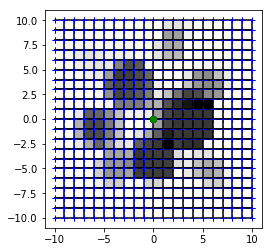

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

# normalize gmap
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)

# plot each cell
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    
fig.canvas.draw()